In [1]:
import numpy as np
from scipy.special import softmax

RNG = np.random.default_rng(seed=0)

n, r, p = 200, 10, 100
x = RNG.multivariate_normal(mean=np.zeros(p), cov=np.eye(p), size=n)

k = 5
beta_prime = RNG.multivariate_normal(mean=np.zeros(r), cov=np.eye(r), size=k)
relevant = RNG.choice(p, r, replace=False)
beta = np.zeros(shape=(k,p))
beta[:, relevant] = beta_prime
probs = softmax(x.dot(beta.T), axis=1)
y = np.array([RNG.multinomial(1, probs[i]) for i in range(n)])
_, y = np.nonzero(y)
y

array([1, 2, 2, 3, 1, 3, 1, 2, 0, 0, 1, 2, 1, 2, 0, 2, 0, 1, 2, 1, 4, 2,
       4, 0, 0, 4, 2, 1, 1, 0, 2, 2, 4, 1, 3, 3, 2, 2, 2, 4, 2, 4, 0, 4,
       4, 2, 2, 0, 0, 0, 4, 1, 1, 0, 4, 0, 0, 4, 1, 4, 2, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 4, 0, 0, 1, 3, 3, 2, 3, 2, 1, 0, 4, 0, 3, 0, 1, 2, 3,
       4, 3, 3, 1, 0, 1, 0, 0, 2, 2, 1, 2, 4, 1, 0, 2, 0, 1, 3, 1, 4, 4,
       0, 0, 3, 4, 2, 1, 0, 2, 1, 0, 1, 4, 1, 1, 4, 3, 4, 2, 1, 2, 1, 4,
       0, 3, 2, 1, 0, 4, 0, 1, 2, 0, 1, 1, 4, 0, 0, 1, 0, 4, 4, 4, 4, 0,
       0, 4, 4, 2, 1, 0, 2, 3, 4, 0, 0, 1, 0, 0, 4, 1, 1, 4, 0, 2, 2, 4,
       2, 0, 2, 0, 1, 0, 2, 3, 1, 1, 4, 3, 1, 2, 1, 4, 0, 4, 1, 0, 1, 3,
       1, 4])

In [2]:
relevant

array([97, 70, 47,  8,  4, 11, 39, 46, 59, 94])

In [9]:
from collections import defaultdict

def incremental_entropy(h_old, n, c_old, c_new):
    delta = c_new - c_old
    if n == 0 or n == -delta: # old or new histogram empty
        return 0.0
    else:
        new_term = c_new*np.log(c_new) if c_new > 0 else 0
        old_term = c_old*np.log(c_old) if c_old > 0 else 0
        return np.log(n+delta)-(new_term + n*(np.log(n)-h_old) - old_term)/(n+delta)

class Binning2:

    @staticmethod
    def trivial(x, y):
        n, _ = x.shape
        k = len(np.unique(y))
        bins = np.zeros(n, dtype=int)
        max_bin = 0
        counts =  defaultdict(int) # np.zeros(n, dtype=int)
        counts[0] = n
        y_counts = defaultdict(lambda : np.zeros(k, int)) # np.zeros(shape=(n, k), dtype=int)
        _, y_counts[0] = np.unique(y, return_counts=True)
        cond_entr = defaultdict(float) # np.zeros(n)
        cond_entr[0] = entropy(y_counts[0], base=2)
        return Binning2(x, y, bins, max_bin, counts, y_counts, cond_entr, cond_entr[0], 1)
    
    @staticmethod
    def from_assignment(x, y, bins):
        binning = Binning2.trivial(x, y)
        for i, dest in enumerate(bins):
            binning.move(i, dest)
        return binning

    def __init__(self, x, y, bins, max_bin, counts, y_counts, cond_entr, mean_cond_entr, non_empty_bin_count):
        n, _ = x.shape
        self.n = n
        self.x = x
        self.y = y
        self.bins = bins
        self.max_bin = max_bin
        self.counts = counts
        self.y_counts = y_counts
        self.cond_entr = cond_entr
        self.mean_cond_entr = mean_cond_entr
        self.non_empty_bin_count = non_empty_bin_count

    def move(self, i, dest):
        orig = self.bins[i]
        if orig == dest: 
            return
        
        self.bins[i] = dest
        c = y[i]
        self.mean_cond_entr = self.mean_cond_entr - self.counts[orig]*self.cond_entr[orig]/self.n - self.counts[dest]*self.cond_entr[dest]/self.n
        self.counts[orig] -= 1
        self.counts[dest] += 1
        self.non_empty_bin_count = self.non_empty_bin_count + (self.counts[dest] == 1) - (self.counts[orig] == 0)
        self.y_counts[orig][c] -= 1
        self.y_counts[dest][c] += 1
        self.cond_entr[orig] = incremental_entropy(self.cond_entr[orig], self.counts[orig]+1, self.y_counts[orig][c]+1, self.y_counts[orig][c])
        self.cond_entr[dest] = incremental_entropy(self.cond_entr[dest], self.counts[dest]-1, self.y_counts[dest][c]-1, self.y_counts[dest][c])
        self.mean_cond_entr = self.mean_cond_entr + self.counts[orig]*self.cond_entr[orig]/self.n + self.counts[dest]*self.cond_entr[dest]/self.n

    def apply_cut_off(self, l, order):
        # TODO: remove code duplication
        split_off_bins = {}

        for i in range(l+1):
            j = order[i]
            b = self.bins[j]
            if b not in split_off_bins:
                self.max_bin += 1
                split_off_bins[b] = self.max_bin
            _b = split_off_bins[b]
            self.move(j, _b)

    def best_cut_off(self, order, obj):
        _max_bin = self.max_bin
        split_off_bins = {}
        origins = np.zeros(n, dtype=int)

        obj_star = float('inf')
        i_star = -1
        # forward
        for i in range(self.n):
            j = order[i]
            b = self.bins[j]
            if b not in split_off_bins:
                self.max_bin += 1
                split_off_bins[b] = self.max_bin
            _b = split_off_bins[b]
            origins[i] = b
            self.move(j, _b)
            obj_value = obj(self)
            if obj_value < obj_star:
                i_star, obj_star = i, obj_value
        
        # rewind
        for i in range(self.n-1, -1, -1):
            j = order[i]
            self.move(j, origins[i])
        self.max_bin = _max_bin

        return i_star, obj_star
        # return i_star, mean_cond_entr_star

In [10]:
from scipy.stats import chi2

def cond_entr_obj(binning):
    return binning.mean_cond_entr


class VariableSelection:

    def __init__(self, delta=0.05, multiple_cuts_per_var=True, verbose=False):
        self.delta = delta
        self.multiple_cuts_per_var = multiple_cuts_per_var
        self.verbose = verbose

    def fit(self, x, y):
        binning = Binning2.trivial(x, y)
        orders = np.argsort(x, axis=0)

        self.n_, self.p_ = x.shape
        selected = np.zeros(self.p_, bool)
        t = 0

        while True:
            j_star, i_star, obj_star = -1, -1, float('inf')
            for j in range(p):
                if selected[j] and not self.multiple_cuts_per_var:
                    continue
                i_j_star, obj_j_star = binning.best_cut_off(orders[:, j], cond_entr_obj)
                if obj_j_star < obj_star:
                    j_star, i_star, obj_star = j, i_j_star, obj_j_star
            
            cond_ent_old = binning.mean_cond_entr
            params_old = binning.non_empty_bin_count
            binning.apply_cut_off(i_star, orders[:, j_star])
            cond_entr_new = binning.mean_cond_entr
            params_new = binning.non_empty_bin_count
            p_value = 1 - chi2.cdf(2*self.n_*(cond_ent_old-cond_entr_new), params_new-params_old)
            # print(cond_ent_old, cond_entr_new, p_value)

            correction = (self.n_*self.p_-t) if self.multiple_cuts_per_var else (self.n_*(self.p_-t))
            if p_value <= self.delta / correction:
                selected[j_star] = True
                if self.verbose: print('.', end='')
            else:
                break
            t += 1
        
        self.selected_ = np.flatnonzero(selected)
        return self

    def transform(self, x, y):
        return x[:, self.selected_], y
    
    def fit_transform(self, x, y):
        return self.fit(x, y).transform(x, y)



In [11]:
var_selection = VariableSelection(0.05)
var_selection.fit(x, y)

In [12]:
var_selection.selected_

array([ 7,  8, 46, 70, 81, 94])

In [13]:
np.intersect1d(relevant, var_selection.selected_)

array([ 8, 46, 70, 94])

In [22]:
import numpy as np
from scipy.special import softmax
from sklearn.base import clone

class Problem:

    @staticmethod
    def randomSparseProblem(p, r, k, random_state=None):
        RNG = np.random.default_rng(seed=random_state)
        beta_prime = RNG.multivariate_normal(mean=np.zeros(r), cov=np.eye(r), size=k)
        relevant = RNG.choice(p, r, replace=False)
        beta = np.zeros(shape=(k,p))
        beta[:, relevant] = beta_prime
        return Problem(beta, relevant)

    def __init__(self, beta, relevant):
        self.beta = beta
        self.relevant = relevant
        self.k, self.p = self.beta.shape

    def rvs(self, n, random_state=None):
        RNG = np.random.default_rng(seed=random_state)
        x = RNG.multivariate_normal(mean=np.zeros(self.p), cov=np.eye(self.p), size=n)
        probs = softmax(x.dot(self.beta.T), axis=1)
        y = np.array([RNG.multinomial(1, probs[i]) for i in range(n)])
        _, y = np.nonzero(y)
        return x, y

k = 5
r, p = 10, 20

reps = 10
ns = np.array([50, 100, 200, 400, 800])
names = ['multiple cuts', 'single cut']
methods = [VariableSelection(0.05, verbose=True), VariableSelection(0.05, False, verbose=True)]

prec = np.zeros(shape=(len(methods), reps, len(ns)))
rec = np.zeros(shape=(len(methods), reps, len(ns)))

problem = Problem.randomSparseProblem(p, r, k, random_state=0)
for j, n in enumerate(ns):
    print('n: ',n)
    for rep in range(reps):
        x, y = problem.rvs(n)
        for i, method in enumerate(methods):
            selection = clone(method, safe=False).fit(x, y) # VariableSelection(0.05, verbose=True).fit(x, y)
            intersection = np.intersect1d(selection.selected_, problem.relevant)
            precision = len(intersection)/len(selection.selected_)
            recall = len(intersection)/len(problem.relevant)
            prec[i, rep, j] = precision
            rec[i, rep, j] = recall
            print('|', end='')
    print()


n:  50
..|..|..|..|...|...|...|...|..|..|...|...|...|...|..|..|...|...|.|.|
n:  100
....|....|....|....|.....|.....|....|.....|.....|.....|....|....|.....|.....|.....|.....|.....|.....|....|....|
n:  200
.......|.......|.......|.......|.......|.......|........|.......|......|......|......|......|.......|.......|.......|.......|.......|.......|........|........|
n:  400
........|.........|.........|.........|........|........|........|.........|........|........|.........|.........|.........|.........|........|........|........|.........|.........|.........|
n:  800
.........|.........|..........|..........|...........|...........|..........|..........|...........|...........|...........|...........|..........|..........|..........|..........|..........|..........|..........|...........|


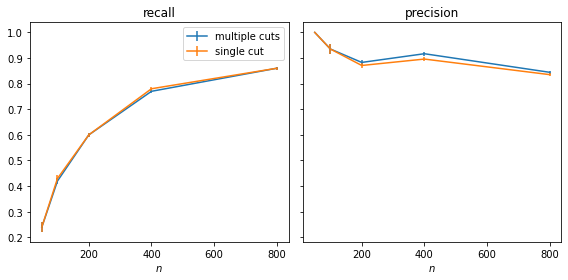

In [23]:
from matplotlib import pyplot as plt

_, axs = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True, sharey=True)
for i in range(len(methods)):
    axs[0].errorbar(ns, rec[i, :, :].mean(axis=0), 1.96*rec[i, :, :].std(axis=0)/ns**0.5, label=names[i])
    axs[1].errorbar(ns, prec[i, :, :].mean(axis=0), 1.96*prec[i, :, :].std(axis=0)/ns**0.5, label=names[i])
axs[0].set_xlabel('$n$')
axs[1].set_xlabel('$n$')
axs[0].set_title('recall')
axs[1].set_title('precision')
axs[0].legend()
plt.show()